In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()
os.chdir('experiments')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from NCP.examples.tools.plot_utils import setup_plots
# setup_plots()
from matplotlib.lines import Line2D

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 8,
    "font.size": 8,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7
}

plt.rcParams.update(tex_fonts)

In [4]:
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
styles = ['-', '--', '-.', ':']
line_cs = [(c, s) for s in styles for c in colours]

## Plot by dataset 

In [4]:
datasets = ['EconDensity', 'ArmaJump', 'SkewNormal', 'LinearGaussian', 'GaussianMixture', 'LinearStudentT']
models = ['NCP_32tanh', 'NCP_32relu', 'KernelMixtureNetwork', 'MixtureDensityNetwork', 'NormalizingFlowEstimator_32tanh', 'NormalizingFlowEstimator_32relu', 'ConditionalKernelDensityEstimation', 'LSConditionalDensityEstimation', 'NeighborKernelDensityEstimation']
models = ['NCP_32relu', 'NormalizingFlowEstimator_32tanh', 'MixtureDensityNetwork','LSConditionalDensityEstimation','ConditionalKernelDensityEstimation', 'KernelMixtureNetwork']
models = ['NCP', 'NormalizingFlowEstimator', 'KernelMixtureNetwork', 'MixtureDensityNetwork', 'LSConditionalDensityEstimation', 'ConditionalKernelDensityEstimation', 'NeighborKernelDensityEstimation', 'NNKCDE', 'RFCDE', 'DDPM', 'FlexCodeModel']
dataset = 'GaussianMixture'

all_results = {}
for model in models:
    results_df = pd.read_pickle(f'{dataset}_{model}_results.pkl')
    #take results_pd, group by n_samples and postprocess, apply np.mean and np.std to scores_pdf and create a new dataframe with the results
    grouped_results = pd.DataFrame()
    for metric in ['hellinger', 'wasserstein1', 'kullback_leibler', 'kolmogorov_smirnov', 'total_variation', 'jensen_shannon']:
        if model in ['NCP_32tanh', 'NCP_32relu', 'NCP']:
            tmp_grouping = pd.DataFrame(results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x: np.nanmean(np.row_stack(x), axis=1)).apply(np.mean))
            tmp_grouping.rename(columns={metric: 'mean_'+metric}, inplace=True)
            tmp_grouping['median_'+metric] = results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x:np.nanmedian(np.row_stack(x), axis=1)).apply(np.median)
            tmp_grouping['std_'+metric] = results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x: np.nanmean(np.row_stack(x), axis=1)).apply(np.std)
            # tmp_grouping['std_'+metric] = results_df.groupby(['n_samples', 'postprocess','seed'])[metric].apply(lambda x: np.nanmean(list(x))).groupby(['n_samples', 'postprocess']).apply(lambda x: np.std(list(x)))       
        else:
            tmp_grouping = pd.DataFrame(results_df.groupby(['n_samples'])[metric].apply(lambda x: np.nanmean(np.row_stack(x), axis=1)).apply(np.mean))
            tmp_grouping.rename(columns={metric: 'mean_'+metric}, inplace=True)
            tmp_grouping['median_'+metric] = results_df.groupby(['n_samples'])[metric].apply(lambda x:np.nanmedian(np.row_stack(x), axis=1)).apply(np.median)
            tmp_grouping['std_'+metric] = results_df.groupby(['n_samples'])[metric].apply(lambda x: np.nanmean(np.row_stack(x), axis=1)).apply(np.std)

        grouped_results = pd.concat([grouped_results, tmp_grouping], axis=1)

    all_results[model] = grouped_results.reset_index()

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()
all_models = ['NCP_32tanh', 'NCP_32relu', 'KernelMixtureNetwork', 'MixtureDensityNetwork', 'NormalizingFlowEstimator_32tanh', 'NormalizingFlowEstimator_32relu', 'ConditionalKernelDensityEstimation', 'LSConditionalDensityEstimation']
models2plot = ['NCP_32relu', 'NormalizingFlowEstimator_32tanh', 'MixtureDensityNetwork', 'LSConditionalDensityEstimation', 'ConditionalKernelDensityEstimation']
models2plot = ['NormalizingFlowEstimator_32tanh', 'NormalizingFlowEstimator']
models2plot = models

for i, metric in enumerate(['hellinger', 'wasserstein1', 'kolmogorov_smirnov', 'total_variation', 'kullback_leibler', 'jensen_shannon']):
    ax = axs[i]
    
    for model in models2plot:
        results = all_results[model]
        if model in ['NCP_32tanh', 'NCP_32relu', 'NCP']:
            for postprocess in ['None', 'centering', 'whitening']:
                n_samples = results[results['postprocess'] == postprocess]['n_samples']
                mean_score = results[results['postprocess'] == postprocess]['mean_'+metric]
                std_score = results[results['postprocess'] == postprocess]['std_'+metric]
                ax.plot(n_samples, mean_score, label= model +' - ' + postprocess)
                ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2)
        else:
            n_samples = results['n_samples']
            mean_score = results['mean_'+metric]
            std_score = results['std_'+metric]
            ax.plot(n_samples, mean_score, label=model)
            ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2)

    ax.set_title(f'Average CDF {metric} distance')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of training samples')
    
plt.legend()
plt.show()

## Plot by metric

In [8]:
datasets = ['EconDensity', 'ArmaJump', 'SkewNormal', 'LinearGaussian', 'GaussianMixture', 'LinearStudentT']
datasets = ['LinearGaussian', 'EconDensity', 'ArmaJump', 'SkewNormal', 'GaussianMixture', 'LGGMD']
# datasets = ['GaussianMixture']
models = ['NCP_32tanh', 'NCP_32relu', 'KernelMixtureNetwork', 'MixtureDensityNetwork', 'NormalizingFlowEstimator_32tanh', 'NormalizingFlowEstimator_32relu', 'ConditionalKernelDensityEstimation', 'LSConditionalDensityEstimation', 'NeighborKernelDensityEstimation']
models = ['NCP_32relu', 'NCP_32tanh', 'NormalizingFlowEstimator_32relu', 'NormalizingFlowEstimator_32tanh','KernelMixtureNetwork', 'MixtureDensityNetwork','LSConditionalDensityEstimation','ConditionalKernelDensityEstimation','NeighborKernelDensityEstimation']
models = ['NCP_32relu','NormalizingFlowEstimator_32relu', 'DDPM', 'NNKCDE', 'RFCDE', 'FlexCodeModel', 'KernelMixtureNetwork', 'MixtureDensityNetwork','ConditionalKernelDensityEstimation', 'LSConditionalDensityEstimation', 'NeighborKernelDensityEstimation']
models = ['NCP', 'NormalizingFlowEstimator', 'NeighborKernelDensityEstimation', 'ConditionalKernelDensityEstimation', 'LinCDE', 'LSConditionalDensityEstimation', 'MixtureDensityNetwork', 'KernelMixtureNetwork']
models = ['NCP_64gelu', 'NormalizingFlowEstimator', 'KernelMixtureNetwork', 'MixtureDensityNetwork', 'LSConditionalDensityEstimation', 'ConditionalKernelDensityEstimation', 'NeighborKernelDensityEstimation', 'NNKCDE', 'RFCDE', 'DDPM', 'FlexCodeModel']
models = ['NCP_64gelu', 'NFlow', 'KMN', 'MixtureDensityNetwork', 'LSConditionalDensityEstimation', 'ConditionalKernelDensityEstimation', 'NeighborKernelDensityEstimation', 'NNKCDE', 'RFCDE', 'FlexCodeModel', 'LinCDE']
models = ['NCP_64gelu', 'NFlow', 'KMN', 'MixtureDensityNetwork', 'LSConditionalDensityEstimation', 'ConditionalKernelDensityEstimation', 'NNKCDE', 'RFCDE', 'FlexCodeModel', 'LinCDE']
# models = ['NCP_32relu', 'NCP_64gelu', 'NormalizingFlowEstimator']
# models = ['NCP_64gelu', 'NormalizingFlowEstimator']
# models = ['NormalizingFlowEstimator']
metrics = ['hellinger', 'wasserstein1', 'kullback_leibler', 'kolmogorov_smirnov', 'total_variation', 'jensen_shannon']
metric = 'kolmogorov_smirnov'

all_results = {}
for model in models:
    grouped_results = {}
    for dataset in datasets:
        results_df = pd.read_pickle(f'{dataset}_{model}_results.pkl')
        #take results_pd, group by n_samples and postprocess, apply np.mean and np.std to scores_pdf and create a new dataframe with the results
        if model in ['NCP_32tanh', 'NCP_32relu', 'NCP', 'NCP_64gelu']:
            tmp_grouping = pd.DataFrame(results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x: np.nanmean(np.row_stack(x))))
            tmp_grouping.rename(columns={metric: 'mean_'+metric}, inplace=True)
            tmp_grouping['median_'+metric] = results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x: np.nanmedian(np.row_stack(x)))
            tmp_grouping['mean_std_'+metric] = results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x: np.nanmean(np.row_stack(x), axis=1)).apply(np.std)
            tmp_grouping['median_std_'+metric] = results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x: np.nanmedian(np.row_stack(x), axis=1)).apply(np.std)
            # tmp_grouping['std_'+metric] = results_df.groupby(['n_samples', 'postprocess','seed'])[metric].apply(lambda x: np.nanmean(list(x))).groupby(['n_samples', 'postprocess']).apply(lambda x: np.std(list(x)))  
        else:
            tmp_grouping = pd.DataFrame(results_df.groupby(['n_samples'])[metric].apply(lambda x: np.nanmean(np.row_stack(x))))
            tmp_grouping.rename(columns={metric: 'mean_'+metric}, inplace=True)
            tmp_grouping['median_'+metric] = results_df.groupby(['n_samples'])[metric].apply(lambda x: np.nanmedian(np.row_stack(x)))
            tmp_grouping['mean_std_'+metric] = results_df.groupby(['n_samples'])[metric].apply(lambda x: np.nanmean(np.row_stack(x), axis=1)).apply(np.std)
            tmp_grouping['median_std_'+metric] = results_df.groupby(['n_samples'])[metric].apply(lambda x: np.nanmedian(np.row_stack(x), axis=1)).apply(np.std)

        grouped_results[dataset] = tmp_grouping.reset_index()
    
    all_results[model] = grouped_results

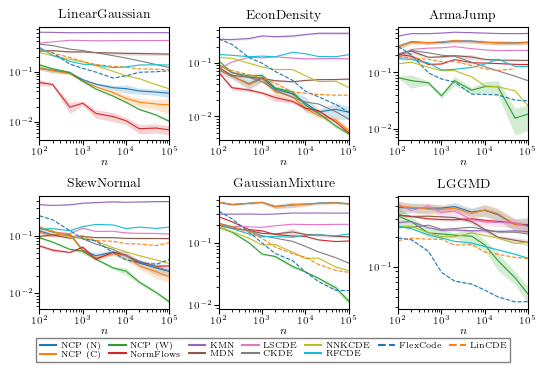

In [9]:
# fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig, axs = plt.subplots(2, 3, figsize=(5.5, 3.5))
# if isinstance(axs, list):
#     axs = axs.flatten()
# else:
#     axs = [axs]

axs = axs.flatten()

all_models = ['NCP_32tanh', 'NCP_32relu', 'KernelMixtureNetwork', 'MixtureDensityNetwork', 'NormalizingFlowEstimator_32tanh', 'NormalizingFlowEstimator_32relu', 'ConditionalKernelDensityEstimation', 'LSConditionalDensityEstimation']
models2plot = ['NCP_32relu',  'NormalizingFlowEstimator_32relu', 'MixtureDensityNetwork', 'LSConditionalDensityEstimation', 'ConditionalKernelDensityEstimation', 'KernelMixtureNetwork']
# models2plot = ['NormalizingFlowEstimator_32relu', 'NormalizingFlowEstimator_32tanh']
models2plot = ['NCP_32relu', 'NormalizingFlowEstimator_32tanh','KernelMixtureNetwork', 'MixtureDensityNetwork','LSConditionalDensityEstimation','ConditionalKernelDensityEstimation','NeighborKernelDensityEstimation']
models2plot = ['NCP_32tanh','NormalizingFlowEstimator_32tanh', 'DDPM', 'NNKCDE', 'RFCDE', 'FlexCodeModel']
models2plot = models

labels = []
for i, dataset in enumerate(datasets):
    ax = axs[i]
    count = 0 
    for model in models2plot:
        results = all_results[model][dataset]
        if model in ['NCP_32tanh', 'NCP_32relu', 'NCP', 'NCP_64gelu']:
            for postprocess in ['None', 'centering', 'whitening']:
                n_samples = results[results['postprocess'] == postprocess]['n_samples']
                mean_score = results[results['postprocess'] == postprocess]['mean_'+metric]
                std_score = results[results['postprocess'] == postprocess]['mean_std_'+metric]
                label = ''.join(c for c in model if c.isupper()) +' - ' + postprocess.capitalize()[0]
                # label = model + ' - ' + postprocess.capitalize()[0]
                labels.append(label)
                ax.plot(n_samples, mean_score, label= label, color = line_cs[count][0], linestyle = line_cs[count][1], linewidth=0.8)
                ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, color = line_cs[count][0], alpha=0.2, linewidth=0)
                count += 1
        else:
            n_samples = results['n_samples']
            mean_score = results['mean_'+metric]
            std_score = results['mean_std_'+metric]
            label = ''.join(c for c in model if c.isupper())
            labels.append(label)
            ax.plot(n_samples, mean_score, label=label, color = line_cs[count][0], linestyle = line_cs[count][1], linewidth=0.8)
            ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2, color = line_cs[count][0], linewidth=0)
            count += 1

    ax.set_title(f'{dataset}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$n$', labelpad=0)
    ax.set_xmargin(0)
    ax.tick_params(axis="x", pad=2)
    ax.tick_params(axis="y", pad=1)

# fig.suptitle(f'Average {metric.capitalize()} distance',size=16)
# ax.legend(bbox_to_anchor=(2.5, -0.2),fancybox=False, shadow=False, ncol=6)

custom_lines = [Line2D([0], [0], color = line_cs[i][0], linestyle = line_cs[i][1]) for i in range(len(models2plot)+2)]
labels = ['NCP (N)', 'NCP (C)', 'NCP (W)', 'NormFlows', 'KMN', 'MDN', 'LSCDE', 'CKDE', 'NNKCDE', 'RFCDE', 'FlexCode', 'LinCDE']
fig.legend(custom_lines, labels, loc = 'lower center', ncol=7, fancybox=False, borderaxespad=-.5, labelspacing=0.1, edgecolor='gray',
           handletextpad=0.5, columnspacing=1, framealpha=1, bbox_transform=fig.transFigure, bbox_to_anchor=(.5, -0.03), fontsize=6)
plt.tight_layout()
plt.show()

fig.savefig(cwd+f'/figures/{metric}_distance.pdf', bbox_inches='tight')

## Plot by metric with DDPM

In [50]:
datasets = ['EconDensity', 'ArmaJump', 'SkewNormal', 'LinearGaussian', 'GaussianMixture', 'LinearStudentT']
datasets = ['LinearGaussian', 'EconDensity', 'ArmaJump', 'SkewNormal', 'GaussianMixture', 'LGGMD']
# datasets = ['GaussianMixture']
models = ['NCP_32tanh', 'NCP_32relu', 'KernelMixtureNetwork', 'MixtureDensityNetwork', 'NormalizingFlowEstimator_32tanh', 'NormalizingFlowEstimator_32relu', 'ConditionalKernelDensityEstimation', 'LSConditionalDensityEstimation', 'NeighborKernelDensityEstimation']
models = ['NCP_32relu', 'NCP_32tanh', 'NormalizingFlowEstimator_32relu', 'NormalizingFlowEstimator_32tanh','KernelMixtureNetwork', 'MixtureDensityNetwork','LSConditionalDensityEstimation','ConditionalKernelDensityEstimation','NeighborKernelDensityEstimation']
models = ['NCP_32relu','NormalizingFlowEstimator_32relu', 'DDPM', 'NNKCDE', 'RFCDE', 'FlexCodeModel', 'KernelMixtureNetwork', 'MixtureDensityNetwork','ConditionalKernelDensityEstimation', 'LSConditionalDensityEstimation', 'NeighborKernelDensityEstimation']
models = ['NCP', 'NormalizingFlowEstimator', 'NeighborKernelDensityEstimation', 'ConditionalKernelDensityEstimation', 'LinCDE', 'LSConditionalDensityEstimation', 'MixtureDensityNetwork', 'KernelMixtureNetwork']
models = ['NCP_64gelu', 'NormalizingFlowEstimator', 'KernelMixtureNetwork', 'MixtureDensityNetwork', 'LSConditionalDensityEstimation', 'ConditionalKernelDensityEstimation', 'NeighborKernelDensityEstimation', 'NNKCDE', 'RFCDE', 'DDPM', 'FlexCodeModel']
models = ['NCP_64gelu', 'DDPM', 'NFlow', 'KMN', 'MixtureDensityNetwork', 'LSConditionalDensityEstimation', 'ConditionalKernelDensityEstimation', 'NeighborKernelDensityEstimation', 'NNKCDE', 'RFCDE', 'FlexCodeModel', 'LinCDE']
# models = ['NCP_32relu', 'NCP_64gelu', 'NormalizingFlowEstimator']
# models = ['NCP_64gelu', 'NormalizingFlowEstimator']
# models = ['NormalizingFlowEstimator']
metrics = ['hellinger', 'wasserstein1', 'kullback_leibler', 'kolmogorov_smirnov', 'total_variation', 'jensen_shannon']
metric = 'kolmogorov_smirnov'

all_results = {}
for model in models:
    grouped_results = {}
    for dataset in datasets:
        results_df = pd.read_pickle(f'{dataset}_{model}_results.pkl')
        #take results_pd, group by n_samples and postprocess, apply np.mean and np.std to scores_pdf and create a new dataframe with the results
        if model in ['NCP_32tanh', 'NCP_32relu', 'NCP', 'NCP_64gelu']:
            tmp_grouping = pd.DataFrame(results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x: np.nanmean(np.row_stack(x))))
            tmp_grouping.rename(columns={metric: 'mean_'+metric}, inplace=True)
            tmp_grouping['median_'+metric] = results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x: np.nanmedian(np.row_stack(x)))
            tmp_grouping['mean_std_'+metric] = results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x: np.nanmean(np.row_stack(x), axis=1)).apply(np.std)
            tmp_grouping['median_std_'+metric] = results_df.groupby(['n_samples', 'postprocess'])[metric].apply(lambda x: np.nanmedian(np.row_stack(x), axis=1)).apply(np.std)
            # tmp_grouping['std_'+metric] = results_df.groupby(['n_samples', 'postprocess','seed'])[metric].apply(lambda x: np.nanmean(list(x))).groupby(['n_samples', 'postprocess']).apply(lambda x: np.std(list(x)))  
        else:
            tmp_grouping = pd.DataFrame(results_df.groupby(['n_samples'])[metric].apply(lambda x: np.nanmean(np.row_stack(x))))
            tmp_grouping.rename(columns={metric: 'mean_'+metric}, inplace=True)
            tmp_grouping['median_'+metric] = results_df.groupby(['n_samples'])[metric].apply(lambda x: np.nanmedian(np.row_stack(x)))
            tmp_grouping['mean_std_'+metric] = results_df.groupby(['n_samples'])[metric].apply(lambda x: np.nanmean(np.row_stack(x), axis=1)).apply(np.std)
            tmp_grouping['median_std_'+metric] = results_df.groupby(['n_samples'])[metric].apply(lambda x: np.nanmedian(np.row_stack(x), axis=1)).apply(np.std)

        grouped_results[dataset] = tmp_grouping.reset_index()
    
    all_results[model] = grouped_results

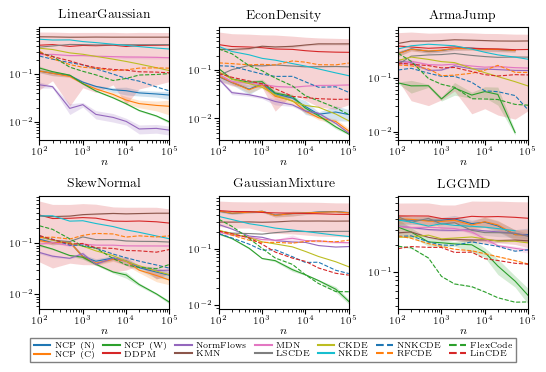

In [51]:
# fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig, axs = plt.subplots(2, 3, figsize=(5.5, 3.5))
# if isinstance(axs, list):
#     axs = axs.flatten()
# else:
#     axs = [axs]

axs = axs.flatten()

all_models = ['NCP_32tanh', 'NCP_32relu', 'KernelMixtureNetwork', 'MixtureDensityNetwork', 'NormalizingFlowEstimator_32tanh', 'NormalizingFlowEstimator_32relu', 'ConditionalKernelDensityEstimation', 'LSConditionalDensityEstimation']
models2plot = ['NCP_32relu',  'NormalizingFlowEstimator_32relu', 'MixtureDensityNetwork', 'LSConditionalDensityEstimation', 'ConditionalKernelDensityEstimation', 'KernelMixtureNetwork']
# models2plot = ['NormalizingFlowEstimator_32relu', 'NormalizingFlowEstimator_32tanh']
models2plot = ['NCP_32relu', 'NormalizingFlowEstimator_32tanh','KernelMixtureNetwork', 'MixtureDensityNetwork','LSConditionalDensityEstimation','ConditionalKernelDensityEstimation','NeighborKernelDensityEstimation']
models2plot = ['NCP_32tanh','NormalizingFlowEstimator_32tanh', 'DDPM', 'NNKCDE', 'RFCDE', 'FlexCodeModel']
models2plot = models

labels = []
for i, dataset in enumerate(datasets):
    ax = axs[i]
    count = 0 
    for model in models2plot:
        results = all_results[model][dataset]
        if model in ['NCP_32tanh', 'NCP_32relu', 'NCP', 'NCP_64gelu']:
            for postprocess in ['None', 'centering', 'whitening']:
                n_samples = results[results['postprocess'] == postprocess]['n_samples']
                mean_score = results[results['postprocess'] == postprocess]['mean_'+metric]
                std_score = results[results['postprocess'] == postprocess]['mean_std_'+metric]
                label = ''.join(c for c in model if c.isupper()) +' - ' + postprocess.capitalize()[0]
                # label = model + ' - ' + postprocess.capitalize()[0]
                labels.append(label)
                ax.plot(n_samples, mean_score, label= label, color = line_cs[count][0], linestyle = line_cs[count][1], linewidth=0.8)
                ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, color = line_cs[count][0], alpha=0.2, linewidth=0)
                count += 1
        else:
            n_samples = results['n_samples']
            mean_score = results['mean_'+metric]
            std_score = results['mean_std_'+metric]
            label = ''.join(c for c in model if c.isupper())
            labels.append(label)
            ax.plot(n_samples, mean_score, label=label, color = line_cs[count][0], linestyle = line_cs[count][1], linewidth=0.8)
            ax.fill_between(n_samples, mean_score - std_score, mean_score + std_score, alpha=0.2, color = line_cs[count][0], linewidth=0)
            count += 1

    ax.set_title(f'{dataset}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$n$', labelpad=0)
    ax.set_xmargin(0)
    ax.tick_params(axis="x", pad=2)
    ax.tick_params(axis="y", pad=1)

# fig.suptitle(f'Average {metric.capitalize()} distance',size=16)
# ax.legend(bbox_to_anchor=(2.5, -0.2),fancybox=False, shadow=False, ncol=6)

custom_lines = [Line2D([0], [0], color = line_cs[i][0], linestyle = line_cs[i][1]) for i in range(len(models2plot)+2)]
labels = ['NCP (N)', 'NCP (C)', 'NCP (W)', 'DDPM', 'NormFlows', 'KMN', 'MDN', 'LSCDE', 'CKDE', 'NKDE', 'NNKCDE', 'RFCDE', 'FlexCode', 'LinCDE']
fig.legend(custom_lines, labels, loc = 'lower center', ncol=7, fancybox=False, borderaxespad=-.5, labelspacing=0.1, edgecolor='gray',
           handletextpad=0.5, columnspacing=1, framealpha=1, bbox_transform=fig.transFigure, bbox_to_anchor=(.5, -0.03), fontsize=6)
plt.tight_layout()
plt.show()

fig.savefig(cwd+f'/figures/{metric}_distance_withDDPM.pdf', bbox_inches='tight')

In [38]:
results_df = pd.read_pickle('ArmaJump_NCP_64gelu_results.pkl')

In [47]:
idxs = results_df[results_df.n_samples == 100000].index
results_df = results_df.drop(idxs)

In [49]:
results_df.to_pickle('ArmaJump_NCP_64gelu_results.pkl')

## Generate latex table

In [62]:
datasets = ['LinearGaussian', 'EconDensity', 'ArmaJump', 'SkewNormal', 'GaussianMixture']
models = ['NCP_32tanh', 'NCP_32relu', 'KernelMixtureNetwork', 'MixtureDensityNetwork', 'NormalizingFlowEstimator_32tanh', 'NormalizingFlowEstimator_32relu', 'ConditionalKernelDensityEstimation', 'LSConditionalDensityEstimation', 'NeighborKernelDensityEstimation']
models = ['NCP_32relu', 'NormalizingFlowEstimator_32tanh', 'MixtureDensityNetwork','LSConditionalDensityEstimation','ConditionalKernelDensityEstimation', 'KernelMixtureNetwork']
models = ['NCP_32relu', 'NCP_32tanh', 'NormalizingFlowEstimator_32relu', 'NormalizingFlowEstimator_32tanh','KernelMixtureNetwork', 'MixtureDensityNetwork','LSConditionalDensityEstimation','ConditionalKernelDensityEstimation']
models = ['NCP_32relu', 'NCP_32tanh', 'NormalizingFlowEstimator_32relu', 'NormalizingFlowEstimator']
models = ['NCP_64gelu', 'NFlow', 'MixtureDensityNetwork', 'LSConditionalDensityEstimation', 'ConditionalKernelDensityEstimation', 'NeighborKernelDensityEstimation', 'NNKCDE', 'RFCDE', 'FlexCodeModel', 'LinCDE']
metrics = ['hellinger', 'wasserstein1', 'kullback_leibler', 'kolmogorov_smirnov', 'total_variation', 'jensen_shannon']
metric = 'kolmogorov_smirnov'
# labels = ['NCP (N)', 'NCP (C)', 'NCP (W)', 'NormFlows', 'MDN', 'LSCDE', 'CKDE', 'NKDE', 'NNKCDE', 'RFCDE', 'FlexCode', 'LinCDE']

all_results = {}
n = int(1e5)
metric = 'kolmogorov_smirnov'
cols = pd.MultiIndex.from_product([datasets, ['Avg', 'Std']])
table = pd.DataFrame(columns= cols)
table.insert(0, 'Model', None)

i=0
for model in models:
    if model in ['NCP_32tanh', 'NCP_32relu', 'NCP_64gelu']:
                for postprocess in ['None', 'centering', 'whitening']:
                    table.loc[i, 'Model'] =''.join(c for c in model if c.isupper()) +' - ' + postprocess.capitalize()[0]
                    i += 1
    else:
        table.loc[i, 'Model'] = ''.join(c for c in model if c.isupper()) 
        i += 1
        
for model in models:
    for dataset in datasets:
        results_df = pd.read_pickle(f'{dataset}_{model}_results.pkl')
        #take results_pd, group by n_samples and postprocess, apply np.mean and np.std to scores_pdf and create a new dataframe with the results
        if model in ['NCP_32tanh', 'NCP_32relu', 'NCP_64gelu']:
            for postprocess in ['None', 'centering', 'whitening']:
                model_short = ''.join(c for c in model if c.isupper()) +' - ' + postprocess.capitalize()[0]
                sub_df = results_df[(results_df.n_samples == n) & (results_df.postprocess == postprocess)]
                mean_value = np.nanmean(np.row_stack(sub_df[metric]),axis=1,dtype='float64').mean()
                std_value = np.nanmean(np.row_stack(sub_df[metric]),axis=1,dtype='float64').std()
                table.loc[table.Model == model_short, dataset]= [mean_value, std_value]

        else:
            model_short = ''.join(c for c in model if c.isupper()) 
            sub_df = results_df[(results_df.n_samples == n)]
            mean_value = np.nanmean(np.row_stack(sub_df[metric]),axis=1).mean()
            std_value = np.nanmean(np.row_stack(sub_df[metric]),axis=1).std()
            table.loc[table.Model == model_short, dataset]= [mean_value, std_value]
table.to_latex(metric + '_' + str(n) +'.tex', index=False, float_format="%.4f", multicolumn_format='c', column_format='lcccccccc')

In [63]:
table

Model LinearGaussian           EconDensity            ArmaJump  \
                       Avg       Std         Avg       Std       Avg   
0   NCP - N       0.036941  0.007029    0.012027  0.003274  0.038267   
1   NCP - C       0.021537   0.00739    0.005452  0.000846  0.030907   
2   NCP - W       0.010124  0.000786    0.004723  0.000216  0.009832   
3        NF       0.006821  0.001438    0.004948   0.00026  0.138012   
4       MDN       0.222655  0.010966    0.049674  0.001284  0.153569   
5     LSCDE       0.419603  0.001061    0.118246  0.001959  0.245159   
6      CKDE       0.119714       0.0    0.008915       0.0  0.071033   
7      NKDE       0.338982       0.0    0.077156       0.0  0.223955   
8    NNKCDE       0.045151       0.0     0.03479       0.0  0.025451   
9     RFCDE       0.134743  0.000546    0.141569  0.000908  0.127314   
10      FCM       0.103997  0.000208    0.011985  0.000061  0.031185   
11     LCDE        0.10767       0.0    0.025056       0.0  0.114217   

             SkewNormal           GaussianMixture            
         Std        Avg       Std             Avg       Std  
0   0.006863   0.023612  0.003811        0.078222  0.006999  
1    0.00632    0.01899  0.003669        0.074092  0.004366  
2   0.002221   0.006981   0.00056        0.074361  0.004308  
3   0.001438   0.029788  0.001186        0.053818  0.006322  
4   0.002763   0.088838  0.003337        0.158933  0.005996  
5   0.001021   0.105994  0.000502        0.220973  0.003525  
6        0.0    0.02423       0.0        0.199552       0.0  
7        0.0   0.122886       0.0        0.291438       0.0  
8        0.0   0.032551       0.0           0.138       0.0  
9   0.000904    0.14049  0.000603        0.102065  0.000873  
10  0.000115   0.038414   0.00007        0.154579  0.000528  
11       0.0   0.075662       0.0         0.19633       0.0